# Training Model

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from   sklearn.model_selection import train_test_split
from   sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import data

In [2]:
filename_alldata = "data/_nanocomposite_data.csv"
alldata = pd.read_csv(filename_alldata, index_col=None, header=0)
# Drop columns which are not used for now
alldata_clean = alldata.drop(['polymer_p2', 'ratio_1_2','filler_2','wt_l2','owner','foaming'], axis=1)  # , inplace=True
alldata_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,HDPEtreated,GNP,11.480530,4.400466
1,HDPEtreated,GNP,7.655316,1.000818
2,HDPEtreated,GNP,5.051461,0.923402
3,HDPEtreated,GNP,21.060864,7.123414
4,HDPEtreated,GNP,23.086466,5.430411


## Prepare Dataset for TensorFlow

### Scaling X and Y data
X data might not need scaling as the range of values is not high.

In [3]:
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.get_params()

{'clip': False, 'copy': True, 'feature_range': (0, 1)}

### The Y label is highly variation
The Y label is the electrical conductivity which is extremely low before the threhold and sudenly increases once the amount of fillers passes the threshold. In this study, the Y values fall mostly in to the range of [1e-3, 1e3], hence, the graph is scaled logarithmically in y-axis.

In [4]:
def safe_log10(data):
    """ A safe function for LOG10 in cases of too small values (close or equal to 0 ) """
    prob_tmp  = np.where(data > 1.0e-10, data, 1.0e-10)
    result    = np.where(data > 1.0e-10, np.log10(prob_tmp), -10)
    return result
    
class superHighVariationScaler:
    """ Standard scaler of Y with multiple scaler 
    Because the range is to high => log10 (values) to play with magnitude order
    To make it organize, use another Scaler following LOG10.
    Default scale is StandardScaler()
    """
    def __init__(self, scaler = None):
        if scaler:
            self.Scaler  = scaler
        else:
            self.Scaler  = StandardScaler()
    def fit_transform(self, data):
        data_loged = safe_log10(data)
        return self.Scaler.fit_transform (data_loged)
    def transform(self, data):
        data_loged = safe_log10(data)
        return self.Scaler.transform (data_loged)
    
    def inverse_transform(self,data):
        data_unloged = self.Scaler.inverse_transform (data)
        return np.float_power(10, data_unloged )

Y_scaler = superHighVariationScaler()  #

You can try other Scaler
```python
Y_scaler = superHighVariationScaler( 
                    MinMaxScaler(feature_range=(0, 1)) )
Y_scaler.Scaler.get_params()
```

### Mapping not Numeric Values / Columns

In [5]:
def mapStringToNum (data):
    polymer_map_list =  {'HDPE':0,'HDPEtreated':1}
    filler_map_list =   {'MWCNT':0,'SWCNT':1,'GNP':2}
    data['polymer_1'] = data['polymer_1'].map(polymer_map_list)
    data['filler_1']  = data['filler_1' ].map(filler_map_list)
    return data

def mapNumToString (data):
    polymer_map_list =  {0:'HDPE',1:'HDPEtreated'}
    filler_map_list =   {0:'MWCNT',1:'SWCNT',2:'GNP'}
    data['polymer_1'] = data['polymer_1'].map(polymer_map_list)
    data['filler_1']  = data['filler_1' ].map(filler_map_list)
    return data

alldata_clean = mapStringToNum(alldata_clean)
alldata_clean.head()

,polymer_1,filler_1,wt_l1,conductivity
0,1,2,11.480530,4.400466
1,1,2,7.655316,1.000818
2,1,2,5.051461,0.923402
3,1,2,21.060864,7.123414
4,1,2,23.086466,5.430411


### Splitting data to training and testing sets

In [6]:
training_data, testing_data = train_test_split(alldata_clean, test_size=0.2, random_state=25) #, random_state=25
print(len(training_data), 'train examples')
print(len(testing_data), 'test examples')
training_data.head()

4000 train examples
1000 test examples


,polymer_1,filler_1,wt_l1,conductivity
1464,1,0,16.218206,107.801470
1394,1,0,7.312086,26.525552
4738,0,1,10.276786,87.759111
2913,0,2,15.577250,0.528244
1757,1,0,4.919024,9.805806


In [7]:
# Split into input features (X) and output labels (Y) variables
X_training = training_data.drop('conductivity', axis=1).values
Y_training = training_data[['conductivity']].values

# Pull out columns for X (data to train with) and Y (value to predict)
X_testing = testing_data.drop('conductivity', axis=1).values
Y_testing = testing_data[['conductivity']].values

### Scaling data

In [8]:
# Scale both the training inputs and outputs
X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)

# It's very important that the training and test data are scaled with the same scaler.
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)

# Model build and complie

## batch_size: 
Too large of a batch size will lead to poor generalization

Smaller batch sizes could shown to have faster convergence to “good” solutions. 

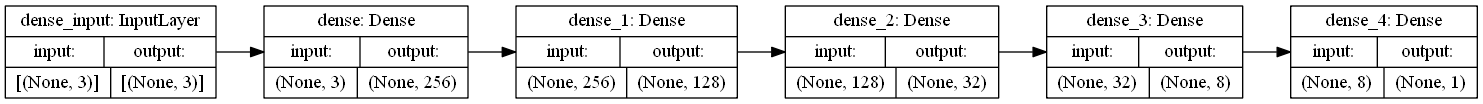

In [9]:
# Create model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(256, activation="relu", input_dim=3))
model.add(tf.keras.layers.Dense(128, activation="relu"))
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(8, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="linear"))

model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6),
             metrics = tf.keras.metrics.MeanSquaredLogarithmicError() )
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

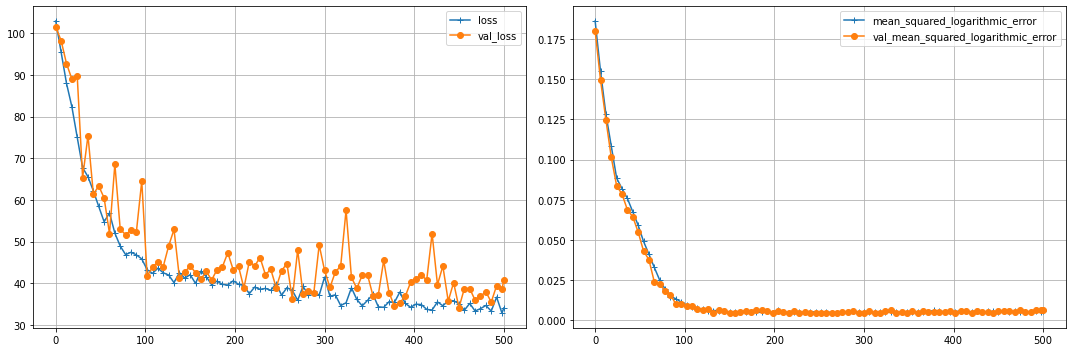

Training is done!


In [10]:
# import PlotRealTime to plot Loss vs Epochs while fitting
from functions import plotRealTime

epochs=500
batch_size=64
step_display = 5 if epochs < 100 else (epochs // 100+1)
#callbacks_list = [plotRealTime(step=step_display), earlyStopper(), reduceLR(), modelCheckpointCallback()]
callbacks_list = [plotRealTime(step=step_display)]

history = model.fit(X_scaled_training, Y_scaled_training, 
                    validation_data=(X_scaled_testing, Y_scaled_testing), 
                    epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, verbose=0)
print("Training is done!")
if epochs != len(history.history['loss']): print("Stopped early!")

In [11]:
print(history.params)

{'verbose': 0, 'epochs': 500, 'steps': 63}


In [12]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_logarithmic_error', 'val_loss', 'val_mean_squared_logarithmic_error'])


## Plotting Training Results

In [13]:
# import smoothArray to smooth array (acts like Convolving signal with noise)
from functions import smoothArray

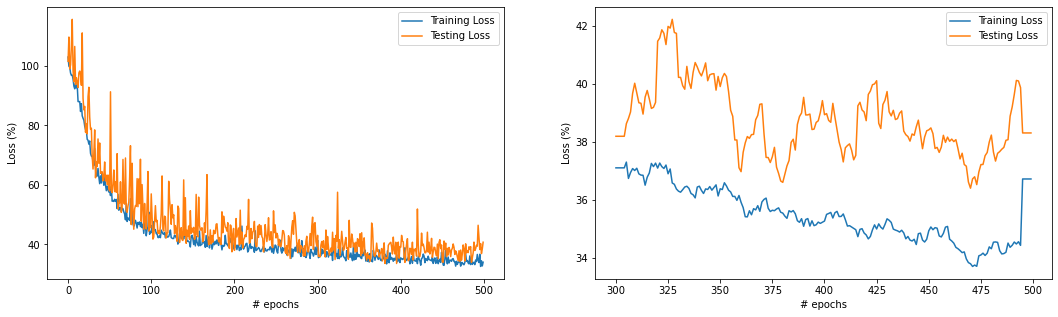

In [14]:
# Check if Stopped early
if epochs != len(history.history['loss']):
    epochs = len(history.history['loss']) # Only real epochs
x_zoom = 200
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,5))
x_range = range(0,epochs)
ax1.plot(x_range, history.history['loss'],     label = "Training Loss")
ax1.plot(x_range, history.history['val_loss'], label = "Testing Loss")
ax1.set(xlabel='# epochs', ylabel='Loss (%)')
ax1.legend()

ax2.plot(x_range[-x_zoom:], smoothArray(history.history['loss'][-x_zoom:]),     label = "Training Loss")
#ax2.plot(x_range[-x_zoom:], history.history['loss'][-x_zoom:],     label = "Training Loss")
ax2.plot(x_range[-x_zoom:], smoothArray(history.history['val_loss'][-x_zoom:]), label = "Testing Loss")
ax2.set(xlabel='# epochs', ylabel='Loss (%)')
ax2.legend();

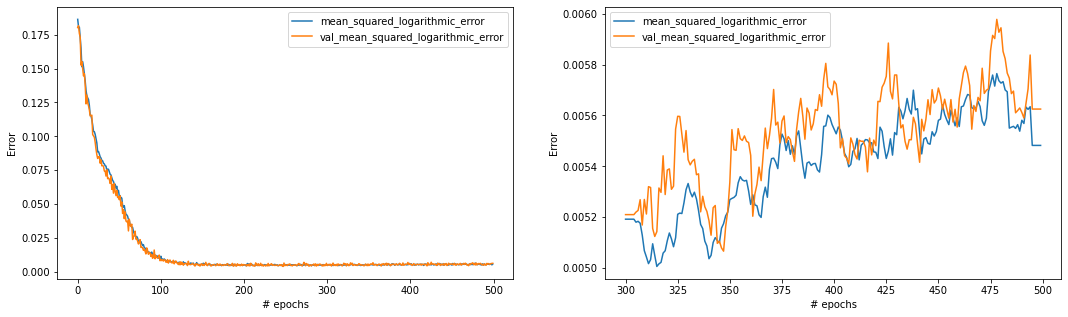

In [15]:
metrics = [x for x in history.history.keys() if 'loss' not in x]
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(18,5))
x_range = range(0,epochs)
for metric in metrics:
    ax1.plot(x_range, history.history[metric],     label = metric)
ax1.set(xlabel='# epochs', ylabel='Error')
ax1.legend()

for metric in metrics:
    ax2.plot(x_range[-x_zoom:], smoothArray(history.history[metric][-x_zoom:]),     label = metric)
ax2.set(xlabel='# epochs', ylabel='Error')
ax2.legend();

## Plotting predicting vs testing data

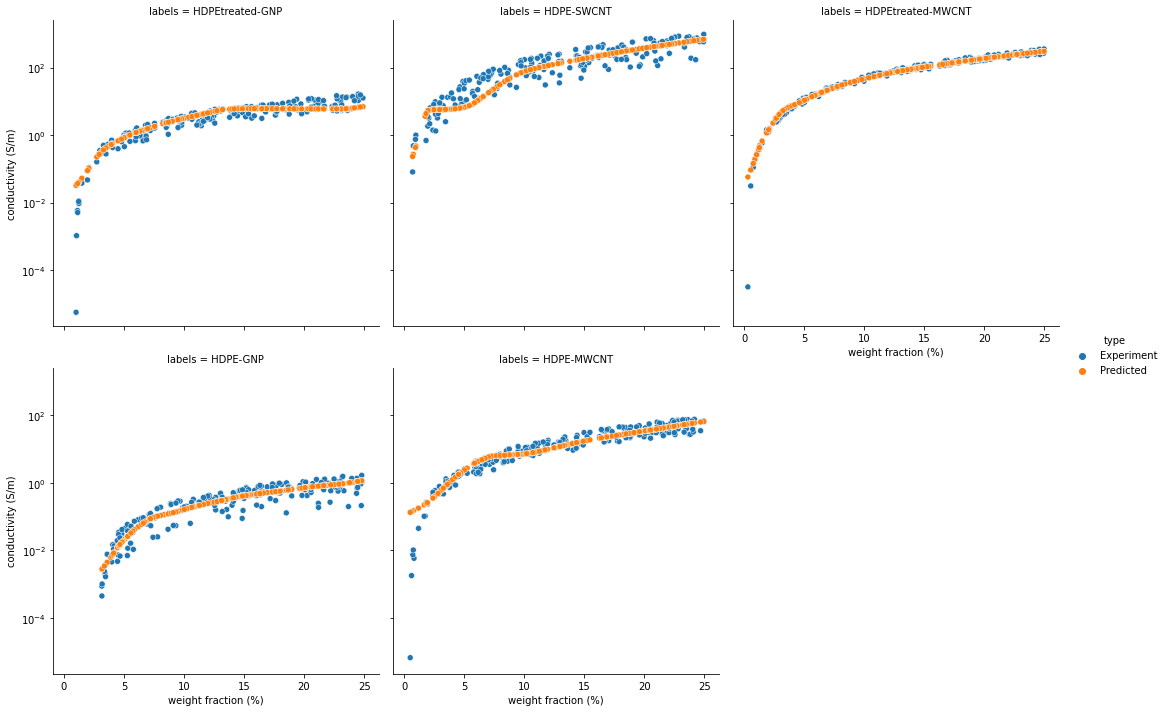

In [16]:
# Calculate predictions
PredValSet = model.predict(X_scaled_testing)
PredValSet2 = Y_scaler.inverse_transform(PredValSet)

compdata = testing_data.copy()
compdata = mapNumToString (compdata)

compdata['labels']    = compdata['polymer_1'] + "-" + compdata['filler_1']
compdata['type'] = 'Experiment'
compdata2 = compdata.copy()
compdata2['type'] = 'Predicted'
compdata2['conductivity'] = PredValSet2

compdata = pd.concat([compdata, compdata2], ignore_index = True)

g = sns.relplot(data=compdata ,x="wt_l1", y ="conductivity", hue="type", col="labels", kind="scatter", col_wrap =3  );
g.set_xlabels("weight fraction (%)");
g.set_ylabels("conductivity (S/m)");
g.set(yscale="log");

## Saving data

In [17]:
model.save('saved/predictor-conductivity-model')
# To be convenient, the SCALERs will be saved 
from pickle import dump
# save the model
#dump(model, open('model.pkl', 'wb'))
# save the scaler
dump(X_scaler, open('saved/X_scaler.pkl', 'wb'))
dump(Y_scaler, open('saved/Y_scaler.pkl', 'wb'))

INFO:tensorflow:Assets written to: saved/predictor-conductivity-model\assets


# Conclusion

## Results are acceptable
The difference between prediction and experiment is within one order of magnitude, which is acceptable.

## Issues
There are a strange behaviour at range around 5%. 

However, our data (conductivity) of different fillers is highly divergent. The carbon nanotube has much higher in intrisic conductivity, leading CNT-based composite has much higher electrical conductivity than the GNP one. Also, the values of threshold in cases of CNT-based composite are much smaller than GNP one. That why there is inconsistent area at 5%.

The X-axis might need scaling with different Scaler which prefers logarithmic scales.